In [18]:
# Fill in your name using the given format
your_name = "Chitsazzadeh, Parisa"

In [5]:
# Uncomment for use in Google Colab. Can be ignored if you run notebooks locally.
#!pip install openml --quiet
#!pip install -U scikit-learn --quiet

# Assignment 1
We will study classifiers on the [Kuzushiji dataset](https://www.openml.org/d/41982).
As you can [read in the paper](https://arxiv.org/abs/1812.01718), Kuzushiji is a handwritten 
Japanese script that was used for thousands of years, but most Japanese natives cannot read
it anymore. We'll try to use machine learning to recognize the characters, and translate them to
modern Japanese (Hiragana) characters.

The dataset that we will use contains scanned 28-by-28 pixel images of such handwritten characters.

In [19]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("0.24.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [20]:
# Download Kuzushiji-MNIST data. Takes a while the first time.
# You may receive a warning about data compression but you can ignore that.
data = openml.datasets.get_dataset(41982)
X, y, _, _ = data.get_data(target=data.default_target_attribute);
X = X/265 # Simple scaling 

# These are the names of the modern characters (our 10 classes)
data_classes = {0:"o", 1: "ki", 2: "su", 3: "tsu", 4: "na", 5: "ha", 
                6: "ma", 7: "ya", 8: "re", 9: "wo"}

In [21]:
# Plotting functions. Don't edit these.
%matplotlib inline
from IPython import display

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

# Plots data instances as 28x28 images
def plot_examples(images, labels, row_length=5):
    nr_rows = math.floor(len(images) / row_length)
    if (len(images) % row_length) > 0:
        nr_rows += 1
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(10, 1.3* nr_rows))
    for i, n in enumerate(images):
        if len(images) > row_length:
            axes[math.floor(i/row_length)][i%row_length].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[math.floor(i/row_length)][i%row_length].set_xlabel(data_classes[int(labels[i])])
            axes[math.floor(i/row_length)][i%row_length].set_xticks(())
            axes[math.floor(i/row_length)][i%row_length].set_yticks(())
        else:
            axes[i].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[i].set_xlabel(data_classes[int(labels[i])])
            axes[i].set_xticks(())
            axes[i].set_yticks(())       
    plt.show();

# Plots the coefficients of the given model as 28x28 heatmaps. 
def plot_coefficients(coef, name):
    """ Renders a 28x28 heatmap of the model's trained coefficients.
    Keyword arguments:
    coef -- the model coefficients
    name -- a title for the produced figure
    """
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    fig.suptitle(name)
    ax.imshow(coef.reshape(28,28))
    ax.set_xticks(()), ax.set_yticks(())

### Peeking at the data
If we plot the characters, we see that there is quite some variation. The same
character can be written in a number of different ways.

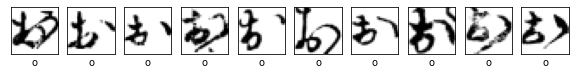

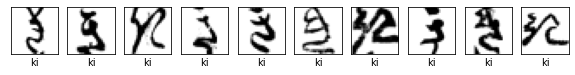

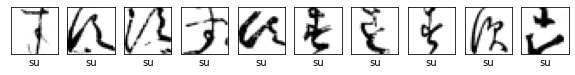

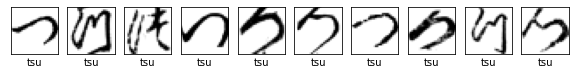

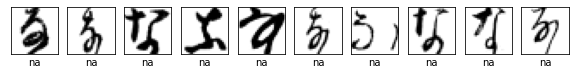

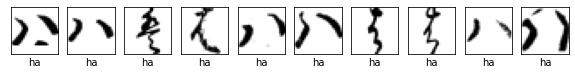

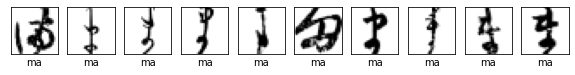

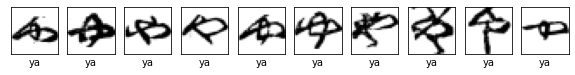

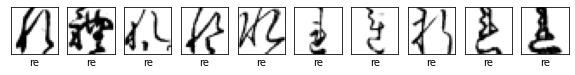

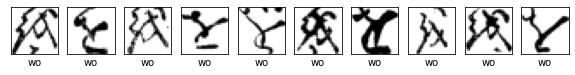

In [22]:
# Gets indices of examples with the given class
def y_class(c):
    return y[y == str(c)].index.values.tolist()[0:10]

for i in range(10):
    plot_examples(X.to_numpy()[y_class(i)], y.to_numpy()[y_class(i)], row_length=10)

### Question 1.1 (2 points)
Implement a function `evaluate_LR` that evaluates a Logistic Regression model for a given regularization constant (C) and returns the train and test score of a 5-fold cross-validation using the accuracy metric.

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Implement
def evaluate_LR(X, y, C):
    """ Evaluate an LR with 5-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    C -- the value for the regularization hyperparameter
    
    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    model = LogisticRegression(C = C, max_iter= 3000)
    scores = cross_validate(estimator = model, X = X, y = y, cv = 5, return_train_score= True)
    return {'train':np.round(np.mean(scores['train_score']), 2), 'test':np.round(np.mean(scores['test_score']), 2)}

In [24]:
#Demonstration
from sklearn.model_selection import train_test_split

Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1, random_state=42)
evaluate_LR(Xs,ys,C=1.0)

{'train': 0.95, 'test': 0.74}

### Question 1.2 (4 points)

Implement a function `plot_curve` that plots the results of `evaluate_LR` on a 10% stratified subsample of the Kuzushiji MNIST dataset vary the C value ranging from 1e-8 to 1e3 (on a log scale, at least 12 values), for the Logistic Regression. You can use the plotting function `plot_live` defined above (carefully read what it does), and add any helper functions you like. Note:  To be clear, you need to pass only 10% of the data to `evaluate_LR`. Using a 10% subsample won't give you optimal performance, but this is meant to make the assignment more doable. If you like you can also use the full dataset.

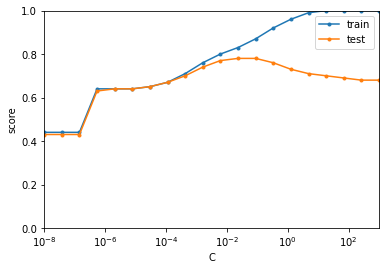

In [25]:
from sklearn.model_selection import train_test_split

# Implement. Do not change the name or signature of this function.
def plot_curve():
    """ Plots the train and test accuracy of logistic regression on a 25% 
    subsample of the given data for different amounts of regularization.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: a plot as described above, with C on the x-axis and accuracy on 
    the y-axis. 
    """
    plot_live(Xs, ys, evaluate_LR, "C" , np.logspace(-8, 3, num= 20))


plot_curve()

### Question 1.3 (2 point)
Interpret the graph. At C=1e-6, is the model underfitting, overfitting, or neither? What about the model trained with C=100?

Below are a number of possible interpretations. Enter the correct answer in value q_1_3 in the code.

'A': Underfitting at C=1e-6, overfitting at C=100.

'B': Overfitting at C=1e-6, underfitting at C=100.

'C': Neither underfitting nor overfitting at C=1e-6, overfitting at C=100.

'D': Neither underfitting nor overfitting at C=1e-6, underfitting at C=100.

'E': Overfitting at C=1e-6, neither underfitting nor overfitting at C=100.

'F': Underfitting at C=1e-6, neither underfitting nor overfitting at C=100.

'G': Neither underfitting nor overfitting at both values for C.

'H': No answer

Add the explanation for choosing your answer.

In [26]:
# Fill in the correct answer. Don't change the name of the variable
q_1_3 ="C"


##Add your explanation below.
By looking at the score axis of the graph 0 mean completely underfit and 1 overfit, so we can assume that the 0.5 can be interpreted as a moderate and good model. 
For C value 1e-6, the score is almost 0.65, let's say around the average score value for a normal model and neither the model is underfitting nor overfitting. However for the second C value 10^2, score is 1 which means our model is overfitting.

### Question 2.1 (4 points)
Use the `plot_coefficients` plotting function to plot a heatmap of the coefficients of three models, one trained with C=10e-6, one with C=0.01, and one with C=10. Only plot the coefficients of the model that separates the character `tsu` from the other characters. You can assume that a one-vs-rest approach is used for multi-class problems, hence the n-th set of coefficients belong to the model that separates the n-th class. You should get three plots in total.

First split the data in a default stratified train-test split. Train the models on the training data and score the accuracy on the test data. Add the C-value and accuracy to the title of the plots. 

Note: You may get convergence warnings. If so, just increase the number of optimization iterations (`max_iter`). Especially models with high C values can take longer to converge (can you guess why?). You can also choose to ignore these warnings since they won't affect the results much.  
Note 2: Recent versions of scikit-learn use a more sophisticated approach than simple one-vs-all, but will still produce one model per class.

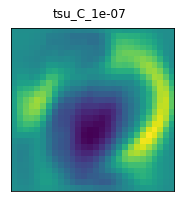

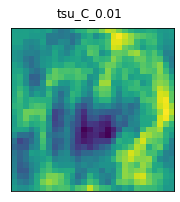

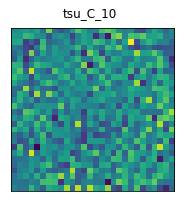

In [36]:
# Implement. Do not change the name or signature of this function.
def plot_tsu_coefficients(X,y):
    """ Plots 28x28 heatmaps showing the coefficients of three Logistic 
    Regression models, each with different amounts of regularization values.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: 3 plots, as described above.
    """
    X_train, Xtest, y_train, y_test = train_test_split(X,y, stratify=y, train_size=0.1, random_state=42)
    C_selected =[10e-6,0.01, 10 ]
    model = [None] * 4
    for i , c in enumerate(C_selected):
        model[i+1] = LogisticRegression( C = c, max_iter= 3000)
        model[i+1].fit(X_train, y_train)
        plot_coefficients(model[i+1].coef_[3], 'tsu_C_'+ str(c))

plot_tsu_coefficients(X,y)

## Question 2.2 (2 points)
Interpret the results. Which model works best? What is each of the models paying attention to when making predictions? Does that make sense - i.e. did the model learn something useful about the character *tsu*? Compare this to the results
of question 1.2 and 1.3: does that help explain the accuracy results?

## Add your answer here
Definitly the tsu_C_10 is not good at all because of it's overfitting and unclear result. 
If only I can choose a value between C_0.01 and C_1e-6, I must say although first output seems more clear and smooth, I'll choose the second model with C_0.01 cause the tsu shape (yellow dots) seem more connected and resembling the character tsu.

## Question 3.1 (4 points)
Let's focus more on the character 'tsu' and the behavior of the model with C=1e-6.

First split the data again in a default stratified train-test split. Train the models on the training data and produce the predictions on the test data.

Next, take the test examples which actually represent 'tsu'. From these, identify the ones which are predicted correctly and which ones are not.

Finally, plot these examples using the `plot_examples` function, together with the predicted class (character). Create two plots: one with 20 examples of 'tsu' characters which are predicted correctly, and a second with 20 examples of 'tsu' characters which are predicted incorrectly by this model.

CORRECT tsus


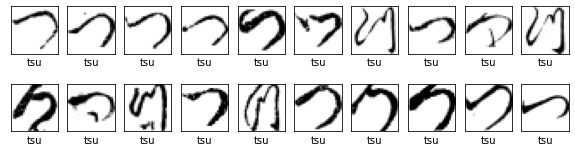

INCORRECT tsus


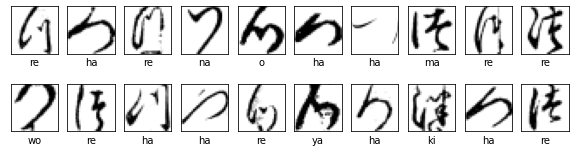

1426 324


In [37]:
def analyze_tsu():
  # Free form coding. Produce the two plots as requested. 
  # Important: the plots must be correct when the notebook is restarted and run from top to bottom.
  
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)
    model = LogisticRegression( C = 10e-6, max_iter= 3000)
    model.fit(X_train, y_train)
    
    # get tsus
    y_test_tsus = y_test[y_test == str(3)]
    tsu_indices = y_test_tsus.index.to_numpy()
    X_test_tsus = X_test.loc[tsu_indices]
    
    # get tsu prediction labels
    predict_tsu_labels = model.predict(X_test_tsus)
    
    # seperate correctly predicted tsus from incorrect ones
    correct_tsu_images = X_test_tsus.loc[predict_tsu_labels == str(3)]
    incorrect_tsu_images = X_test_tsus.loc[predict_tsu_labels != str(3)]
    incorrect_tsu_labels = predict_tsu_labels[predict_tsu_labels != str(3)]
    
    print("CORRECT tsus")
    plot_examples(correct_tsu_images.to_numpy()[:20], y_test_tsus.to_numpy()[:20], row_length=10)
    
    print("INCORRECT tsus")
    plot_examples(incorrect_tsu_images.to_numpy()[:20], incorrect_tsu_labels[:20], row_length=10)
    
    print(len(correct_tsu_images), len(incorrect_tsu_images))
    

analyze_tsu()

## Question 3.2 (2 points)
Interpret the results. Can you explain which kinds of 'tsu' characters are predicted correctly and which ones are not? Compare this with what you observed in question 2.1 and 2.2. What does that tell you about the model?

In [ ]:
#You can add the code here for the analysis. 
#This code is optional as the grading will be done based on the explanation provided below. However, the code will help you to get insights.

## Add your answer here
Since these incorrect ones look more like the other vertical shape characters than the commonly horizontal shape of "tsu", it could be one of the reasons. The second and third shape of "tsu" character, could be the cause of wrong predictions that resembles "re", "ma" and "ki".
Also we can recognize that the "ha" character is also incorrectly predicted as tsu because of its similarity in it's angles, having sort of oval or S shape as well as being horizontal.

In [38]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.
